# Introduction and Business Problem

## Introduction

As an international student, schooling at in Huntington, West Virginia has been fun and exciting but there was one problem. I had issues looking for the best restaurants around. It can be difficult finding restaurants that are worth going to and where they are since I am new in the environment. 

## Business Problem

For this project, we will be using Foursquare to create a simple guide on where to eat based on Foursquare categories, likes and geographic location data for the restaurants in Huntington. Using clusters, we will then group similar restaurants based on Foursquare user feedbacks so that students can easily determine which type of restaurant is best for them based on these criteria.

## Data Requirements

For this assignment, I will be utilizing the Foursquare API to pull the following location data on restaurants in Huntington, WV:

* Venue Name
* Venue ID
* Venue Location
* Venue Category
* Count of Likes

## Data Acquisition Approach

To acquire the data mentioned above, we will need to do the following:

* Get geolocator lat and long coordinates for Huntington, WV
* Use Foursquare API to get a list of all venues in Huntington
* Get venue name, venue ID, location, category, and likes

## Algorithm Used

We will take the gathered data (see above in Data Acquisition Approach and Data Required sections) and will create a k-means clustering algorithm that groups restaurants into 4-5 clusters so that people looking to eat in Huntington can easily see which restaurants are the best to eat at, what cuisine is available and where in Huntington they can look to eat.

## Data Pulling, Preparation and cleaning

We will import our necessary packages and start pulling our data for data prep and usage.

In [5]:
!pip install beautifulsoup4

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#import beautiful soup
from urllib.request import urlopen
from bs4 import BeautifulSoup


print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


## Finding the geo data for Huntington

In [6]:
address = 'Huntington, West Virginia'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Huntington are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Huntington are 38.4192496, -82.445154.


## FourSquare Part 1
Entering in our information into the Foursquare API to access it.

In [9]:
CLIENT_ID = '4QNT4CIIY5NZRL3E5202TFE4CPAWG0NNLHIMB412MZQ4Z2IW' # your Foursquare ID
CLIENT_SECRET = 'UT0JQ0HU22RNI1J1XEPHP3HTT0WEGVN5TTI3NIG4UGOCD53K' # your Foursquare Secret
VERSION = '20200604' # Foursquare API version

print('Your credentails have been entered')

Your credentails have been entered


## FourSquare Part 2
Creating a URL for all of the venues in Huntington

In [11]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

print('url created.')

url created.


## FourSquare Part 3
Pulling the JSON for the URL of venues.

In [12]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ed9493a1187ee001b388f1a'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Huntington',
  'headerFullLocation': 'Huntington',
  'headerLocationGranularity': 'city',
  'totalResults': 50,
  'suggestedBounds': {'ne': {'lat': 38.4237496045, 'lng': -82.43942114736963},
   'sw': {'lat': 38.4147495955, 'lng': -82.45088685263038}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5212e0f58bbdc9aa74d62320',
       'name': 'Summit Beer Station',
       'location': {'address': '321 9th St',
        'lat': 38.421003057323034,
        'lng': -82.44400799274443,
        'labeledLatLngs': [{'label': 'display',
         

## Foursquare Part 4
Now we start pulling the data from Foursquare into a dataframe so we can manipulate and use it.

In [13]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
#pull the actual data from the Foursquare API

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,Summit Beer Station,5212e0f58bbdc9aa74d62320,Beer Bar,38.421003,-82.444008
1,Hibachi Japanese Steakhouse,4b55e9aaf964a52014f627e3,Japanese Restaurant,38.420616,-82.444451
2,Jim's Steak & Spaghetti House,4b7200a4f964a52079692de3,American Restaurant,38.419721,-82.442698
3,Taste of Asia,4b574da0f964a5204c3028e3,Asian Restaurant,38.421826,-82.445146
4,Sheetz,58e9b0a8e9dad13680aa2a2d,Gas Station,38.417993,-82.445281
5,The V Club,4b63bcaff964a520048f2ae3,Bar,38.417549,-82.444946
6,21 At The Frederick Inc,4b6210b6f964a52069332ae3,Steakhouse,38.421096,-82.442803
7,The Peddler,57e46d36498ec369cac431f1,Gastropub,38.421795,-82.444972
8,Schlotzsky's,4b5b573ef964a520f5f528e3,Restaurant,38.420774,-82.444275
9,Pullman Square,4b4899d9f964a520355026e3,Shopping Mall,38.422185,-82.443624


In [15]:
#fix the column names so they look relatively normal
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues

,name,id,categories,lat,lng
0,Summit Beer Station,5212e0f58bbdc9aa74d62320,Beer Bar,38.421003,-82.444008
1,Hibachi Japanese Steakhouse,4b55e9aaf964a52014f627e3,Japanese Restaurant,38.420616,-82.444451
2,Jim's Steak & Spaghetti House,4b7200a4f964a52079692de3,American Restaurant,38.419721,-82.442698
3,Taste of Asia,4b574da0f964a5204c3028e3,Asian Restaurant,38.421826,-82.445146
4,Sheetz,58e9b0a8e9dad13680aa2a2d,Gas Station,38.417993,-82.445281
5,The V Club,4b63bcaff964a520048f2ae3,Bar,38.417549,-82.444946
6,21 At The Frederick Inc,4b6210b6f964a52069332ae3,Steakhouse,38.421096,-82.442803
7,The Peddler,57e46d36498ec369cac431f1,Gastropub,38.421795,-82.444972
8,Schlotzsky's,4b5b573ef964a520f5f528e3,Restaurant,38.420774,-82.444275
9,Pullman Square,4b4899d9f964a520355026e3,Shopping Mall,38.422185,-82.443624


In [17]:
# find a list of unique categories from the API so we can see what may or may not fit for restaurants

nearby_venues['categories'].unique()

array(['Beer Bar', 'Japanese Restaurant', 'American Restaurant',
       'Asian Restaurant', 'Gas Station', 'Bar', 'Steakhouse',
       'Gastropub', 'Restaurant', 'Shopping Mall', 'Burrito Place',
       'Beer Garden', 'Thai Restaurant', 'Indian Restaurant',
       'Cupcake Shop', 'Coffee Shop', 'Pizza Place', 'Design Studio',
       'Cocktail Bar', 'Theater', 'Multiplex', 'Flower Shop', 'Hotel',
       'Bookstore', 'Video Game Store', 'Mobile Phone Shop', 'Bagel Shop',
       'Bank', 'Gay Bar', 'Chinese Restaurant', 'Clothing Store',
       'Event Space', 'Mexican Restaurant', 'Wings Joint', 'Optical Shop',
       'Greek Restaurant', 'Pharmacy', 'Ice Cream Shop', 'Office'],
      dtype=object)

In [18]:
# creating a list of categorie to remove from our dataframe because they are not restaurants
# I am sure there is a function that can be written to do this at scale but since it was a small list, I did it manually

removal_list = ['Gas Station', 'Shopping Mall', 'Design Studio', 'Theater', 'Sporting Goods Shop', 'Multiplex', 'Flower Shop',
               'Hotel', 'Bookstore', 'Video Game Store', 'Mobile Phone Shop', 'Bank', 'Clothing Store', 'Event Space', 
               'Optical Shop', 'Pharmacy', 'Ice Cream Shop', 'Office']

nearby_venues2 = nearby_venues.copy()

#getting a clear dataframe of just restaurants
nearby_venues2 = nearby_venues2[~nearby_venues2['categories'].isin(removal_list)]
nearby_venues2

,name,id,categories,lat,lng
0,Summit Beer Station,5212e0f58bbdc9aa74d62320,Beer Bar,38.421003,-82.444008
1,Hibachi Japanese Steakhouse,4b55e9aaf964a52014f627e3,Japanese Restaurant,38.420616,-82.444451
2,Jim's Steak & Spaghetti House,4b7200a4f964a52079692de3,American Restaurant,38.419721,-82.442698
3,Taste of Asia,4b574da0f964a5204c3028e3,Asian Restaurant,38.421826,-82.445146
5,The V Club,4b63bcaff964a520048f2ae3,Bar,38.417549,-82.444946
6,21 At The Frederick Inc,4b6210b6f964a52069332ae3,Steakhouse,38.421096,-82.442803
7,The Peddler,57e46d36498ec369cac431f1,Gastropub,38.421795,-82.444972
8,Schlotzsky's,4b5b573ef964a520f5f528e3,Restaurant,38.420774,-82.444275
10,Black Sheep Burritos & Brews,4e80b3a402d5849fd6856143,Burrito Place,38.422399,-82.444426
11,Bahnhof - Wvrst-Haus & Bier Garden,57ebd42b498eb09f6a0d6963,Beer Garden,38.416240,-82.444526


## Foursquare Part 5
Now let's get a list of venue ids so we can pull likes and add to our dataframe.

In [19]:
#let's get a list of venues
venue_id_list = nearby_venues2['id'].tolist()
venue_id_list

['5212e0f58bbdc9aa74d62320',
 '4b55e9aaf964a52014f627e3',
 '4b7200a4f964a52079692de3',
 '4b574da0f964a5204c3028e3',
 '4b63bcaff964a520048f2ae3',
 '4b6210b6f964a52069332ae3',
 '57e46d36498ec369cac431f1',
 '4b5b573ef964a520f5f528e3',
 '4e80b3a402d5849fd6856143',
 '57ebd42b498eb09f6a0d6963',
 '53b39631498e3a1b1773f30e',
 '56a9694c498edb01e8c54406',
 '4b6385f6f964a520ad802ae3',
 '4d88d3d3bc848cfa0e50b52b',
 '4b47a4b4f964a520be3826e3',
 '4fef2816e4b0f5b9d81da608',
 '4b5bdea8f964a520be1a29e3',
 '4e59677f52b1b78b819cf241',
 '4bd4e2bc6f649521755b6eec',
 '4b68edfcf964a520a4932be3',
 '50e86049e4b06559d04c6157',
 '4da5a8e05614db9a39b96d7d',
 '4b5a9f3cf964a5202fce28e3',
 '4b565304f964a520520b28e3',
 '4b5a3c3cf964a52070b628e3',
 '4e5a76e6b61c4aaa3e0ab6c3',
 '4b55ebe6f964a52094f627e3',
 '5aa99755d0a1494a960e40d5']

In [20]:
#set up to pull the likes from the API based on venue ID

url_list = []
like_list = []
json_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)

[19, 20, 51, 45, 16, 8, 14, 11, 79, 28, 10, 6, 19, 9, 74, 16, 8, 8, 8, 39, 8, 3, 7, 19, 8, 30, 15, 1]


In [21]:
#double check that we did not lose any venues based on if likes were available

print(len(like_list))
print(len(venue_id_list))

28
28


## Data Prep Intro
The thought process behind this is that likes are a proxy for quality. The more likes there are, the better the restaurant is. This might be incorrect but API call issues (how many we can use for free) holds me back from getting price / rating data. We will then bin this data into a quality categorical variables so we can cluster appropriately.

We are also going to create new categorical variables for the restaurants to better group them based on type of cuisine. This way you can look for good American food or what type of food might be best to eat in Huntington if you are new to the area.

## Data Prep Part 1
Now let's start prepping our data for clustering. This will include combining data from different lists, creating new categorical data to be used, binning data and then encoding the data for clustering.

In [27]:
#let's make a copy of our initial dataframe just in case anything goes wrong

huntington_venues = nearby_venues2.copy()
huntington_venues.head()

,name,id,categories,lat,lng
0,Summit Beer Station,5212e0f58bbdc9aa74d62320,Beer Bar,38.421003,-82.444008
1,Hibachi Japanese Steakhouse,4b55e9aaf964a52014f627e3,Japanese Restaurant,38.420616,-82.444451
2,Jim's Steak & Spaghetti House,4b7200a4f964a52079692de3,American Restaurant,38.419721,-82.442698
3,Taste of Asia,4b574da0f964a5204c3028e3,Asian Restaurant,38.421826,-82.445146
5,The V Club,4b63bcaff964a520048f2ae3,Bar,38.417549,-82.444946


## Data Prep Part 2
Let's combine our list of likes into our dataframe.

In [28]:
# add in the list of likes

huntington_venues['total likes'] = like_list
huntington_venues.head()

,name,id,categories,lat,lng,total likes
0,Summit Beer Station,5212e0f58bbdc9aa74d62320,Beer Bar,38.421003,-82.444008,19
1,Hibachi Japanese Steakhouse,4b55e9aaf964a52014f627e3,Japanese Restaurant,38.420616,-82.444451,20
2,Jim's Steak & Spaghetti House,4b7200a4f964a52079692de3,American Restaurant,38.419721,-82.442698,51
3,Taste of Asia,4b574da0f964a5204c3028e3,Asian Restaurant,38.421826,-82.445146,45
5,The V Club,4b63bcaff964a520048f2ae3,Bar,38.417549,-82.444946,16


## Data Prep 3
Let's look at our like data to set bins.

In [29]:
# now let's bin total likes

print(huntington_venues['total likes'].max())
print(huntington_venues['total likes'].min())
print(huntington_venues['total likes'].median())
print(huntington_venues['total likes'].mean())

79
1
14.5
20.678571428571427


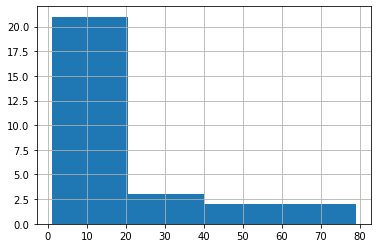

In [30]:
# let's visualize our total likes based on a histogram

import matplotlib.pyplot as plt
huntington_venues['total likes'].hist(bins=4)
plt.show()

In [31]:
# what are the bins we want to use?

print(np.percentile(huntington_venues['total likes'], 25))
print(np.percentile(huntington_venues['total likes'], 50))
print(np.percentile(huntington_venues['total likes'], 75))

8.0
14.5
22.0


In [32]:
# now we have our bin values so let's set them to the appropriate values
# less than 8, 8-14, 14-22, 22>
# poor, below avg, abv avg, great

poor = huntington_venues['total likes']<=8
below_avg = huntington_venues[(huntington_venues['total likes']>8) & (huntington_venues['total likes']<=14)]
abv_avg = huntington_venues[(huntington_venues['total likes']>14) & (huntington_venues['total likes']<=22)]
great = huntington_venues['total likes']>22

In [60]:
# let's set up a function that will re-categorize our restaurants based on likes

def conditions(s):
    if s['total likes']<=8:
        return 'poor'
    if s['total likes']<=14:
        return 'below average'
    if s['total likes']<=22:
        return 'above average'
    if s['total likes']>22:
        return 'great!'

huntington_venues['total likes_cat']=huntington_venues.apply(conditions, axis=1)

In [61]:
huntington_venues

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,Summit Beer Station,5212e0f58bbdc9aa74d62320,Beer Bar,38.421003,-82.444008,19,above average,bars,0
1,Hibachi Japanese Steakhouse,4b55e9aaf964a52014f627e3,Japanese Restaurant,38.420616,-82.444451,20,above average,euro asia indian food,0
2,Jim's Steak & Spaghetti House,4b7200a4f964a52079692de3,American Restaurant,38.419721,-82.442698,51,great!,american food,2
3,Taste of Asia,4b574da0f964a5204c3028e3,Asian Restaurant,38.421826,-82.445146,45,great!,euro asia indian food,2
5,The V Club,4b63bcaff964a520048f2ae3,Bar,38.417549,-82.444946,16,above average,bars,0
6,21 At The Frederick Inc,4b6210b6f964a52069332ae3,Steakhouse,38.421096,-82.442803,8,poor,american food,1
7,The Peddler,57e46d36498ec369cac431f1,Gastropub,38.421795,-82.444972,14,below average,bars,3
8,Schlotzsky's,4b5b573ef964a520f5f528e3,Restaurant,38.420774,-82.444275,11,below average,american food,3
10,Black Sheep Burritos & Brews,4e80b3a402d5849fd6856143,Burrito Place,38.422399,-82.444426,79,great!,mex southam food,2
11,Bahnhof - Wvrst-Haus & Bier Garden,57ebd42b498eb09f6a0d6963,Beer Garden,38.416240,-82.444526,28,great!,bars,2


In [62]:
# let's star the process for re-categorizing the categories

huntington_venues['categories'].unique()

array(['Beer Bar', 'Japanese Restaurant', 'American Restaurant',
       'Asian Restaurant', 'Bar', 'Steakhouse', 'Gastropub', 'Restaurant',
       'Burrito Place', 'Beer Garden', 'Thai Restaurant',
       'Indian Restaurant', 'Cupcake Shop', 'Coffee Shop', 'Pizza Place',
       'Cocktail Bar', 'Bagel Shop', 'Gay Bar', 'Chinese Restaurant',
       'Mexican Restaurant', 'Wings Joint', 'Greek Restaurant'],
      dtype=object)

In [63]:
# let's create our new categories and create a function to apply those to our existing data

bars = ['Pub', 'Beer Bar', 'Bar', 'Gastropub', 'Beer Garden', 'Gay Bar', 'Cocktail Bar']
other = ['Bagel Shop', 'Coffee Shop', 'Cupcake Shop', 'Coffee Shop']
euro_asia_indian_food = ['Thai Restaurant','Chinese Restaurant', 'Indian Restaurant', 'Japanese Restaurant', 'Asian Restaurant', 'Greek Restaurant']
mex_southam_food = ['Mexican Restaurant', 'Burrito Place']
american_food = ['Restaurant', 'American Restaurant', 'Steakhouse', 'Wings Joint']
italian_food = ['Pizza Place']

def conditions2(s):
    if s['categories'] in bars:
        return 'bars'
    if s['categories'] in other:
        return 'other'
    if s['categories'] in euro_asia_indian_food:
        return 'euro asia indian food'
    if s['categories'] in mex_southam_food:
        return 'mex southam food'
    if s['categories'] in american_food:
        return 'american food'
    if s['categories'] in italian_food:
        return 'italian food'

huntington_venues['categories_new']=huntington_venues.apply(conditions2, axis=1)

In [64]:
huntington_venues

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,Summit Beer Station,5212e0f58bbdc9aa74d62320,Beer Bar,38.421003,-82.444008,19,above average,bars,0
1,Hibachi Japanese Steakhouse,4b55e9aaf964a52014f627e3,Japanese Restaurant,38.420616,-82.444451,20,above average,euro asia indian food,0
2,Jim's Steak & Spaghetti House,4b7200a4f964a52079692de3,American Restaurant,38.419721,-82.442698,51,great!,american food,2
3,Taste of Asia,4b574da0f964a5204c3028e3,Asian Restaurant,38.421826,-82.445146,45,great!,euro asia indian food,2
5,The V Club,4b63bcaff964a520048f2ae3,Bar,38.417549,-82.444946,16,above average,bars,0
6,21 At The Frederick Inc,4b6210b6f964a52069332ae3,Steakhouse,38.421096,-82.442803,8,poor,american food,1
7,The Peddler,57e46d36498ec369cac431f1,Gastropub,38.421795,-82.444972,14,below average,bars,3
8,Schlotzsky's,4b5b573ef964a520f5f528e3,Restaurant,38.420774,-82.444275,11,below average,american food,3
10,Black Sheep Burritos & Brews,4e80b3a402d5849fd6856143,Burrito Place,38.422399,-82.444426,79,great!,mex southam food,2
11,Bahnhof - Wvrst-Haus & Bier Garden,57ebd42b498eb09f6a0d6963,Beer Garden,38.416240,-82.444526,28,great!,bars,2


## Data Prep Part 4
Now let's create dummy variables for our total likes and categories so we can cluster.

In [65]:
# one hot encoding
huntington_onehot = pd.get_dummies(huntington_venues[['categories_new', 'total likes_cat']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
huntington_onehot['Name'] = huntington_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [huntington_onehot.columns[-1]] + list(huntington_onehot.columns[:-1])
huntington_onehot = huntington_onehot[fixed_columns]

huntington_onehot.head()

,Name,american food,bars,euro asia indian food,italian food,mex southam food,other,above average,below average,great!,poor
0,Summit Beer Station,0,1,0,0,0,0,1,0,0,0
1,Hibachi Japanese Steakhouse,0,0,1,0,0,0,1,0,0,0
2,Jim's Steak & Spaghetti House,1,0,0,0,0,0,0,0,1,0
3,Taste of Asia,0,0,1,0,0,0,0,0,1,0
5,The V Club,0,1,0,0,0,0,1,0,0,0


## Clustering Part 1
Now let's run our k-means clustering algorithm to get our labels

In [66]:
cluster_df = huntington_onehot.drop('Name', axis=1)

k_clusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 2, 0, 1, 3, 3, 2, 2], dtype=int32)

## Clustering Part 2
Let's add our cluster labels back into our original dataframe.

In [67]:
huntington_venues['label'] = kmeans.labels_
huntington_venues.head()

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,Summit Beer Station,5212e0f58bbdc9aa74d62320,Beer Bar,38.421003,-82.444008,19,above average,bars,0
1,Hibachi Japanese Steakhouse,4b55e9aaf964a52014f627e3,Japanese Restaurant,38.420616,-82.444451,20,above average,euro asia indian food,0
2,Jim's Steak & Spaghetti House,4b7200a4f964a52079692de3,American Restaurant,38.419721,-82.442698,51,great!,american food,2
3,Taste of Asia,4b574da0f964a5204c3028e3,Asian Restaurant,38.421826,-82.445146,45,great!,euro asia indian food,2
5,The V Club,4b63bcaff964a520048f2ae3,Bar,38.417549,-82.444946,16,above average,bars,0


## Clustering Part 3
Now let's visualize what our clusters look like for Huntington.

In [68]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=15)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(huntington_venues['lat'], huntington_venues['lng'], huntington_venues['name'], huntington_venues['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


## Clustering Part 4
Now let's see what is in each of our clusters

### Cluster 1
characteristics
* Poor quality food

In [70]:
huntington_venues.loc[huntington_venues['label']==1]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
6,21 At The Frederick Inc,4b6210b6f964a52069332ae3,Steakhouse,38.421096,-82.442803,8,poor,american food,1
13,Surin Of Thailand,56a9694c498edb01e8c54406,Thai Restaurant,38.422272,-82.443893,6,poor,euro asia indian food,1
19,Hank's,4b5bdea8f964a520be1a29e3,Bar,38.421173,-82.441654,8,poor,bars,1
20,Jockey Club,4e59677f52b1b78b819cf241,Cocktail Bar,38.420992,-82.442805,8,poor,bars,1
23,St. Mark's Bar,4bd4e2bc6f649521755b6eec,Bar,38.420954,-82.442966,8,poor,bars,1
27,Le Bistro,50e86049e4b06559d04c6157,American Restaurant,38.421769,-82.443733,8,poor,american food,1
31,NY Bagel Cafe and Brew,4da5a8e05614db9a39b96d7d,Bagel Shop,38.421018,-82.442695,3,poor,other,1
34,Stonewall Club,4b5a9f3cf964a5202fce28e3,Gay Bar,38.416988,-82.443751,7,poor,bars,1
40,Rio Grande,4b5a3c3cf964a52070b628e3,Mexican Restaurant,38.420850,-82.443480,8,poor,mex southam food,1
45,Navarino Bay,5aa99755d0a1494a960e40d5,Greek Restaurant,38.421545,-82.445476,1,poor,euro asia indian food,1


## Cluster 3
characteristics
* below average quality food

In [71]:
huntington_venues.loc[huntington_venues['label']==3]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
7,The Peddler,57e46d36498ec369cac431f1,Gastropub,38.421795,-82.444972,14,below average,bars,3
8,Schlotzsky's,4b5b573ef964a520f5f528e3,Restaurant,38.420774,-82.444275,11,below average,american food,3
12,The Lantern,53b39631498e3a1b1773f30e,Bar,38.420538,-82.445058,10,below average,bars,3
15,Paula Vega Cakes,4d88d3d3bc848cfa0e50b52b,Cupcake Shop,38.421578,-82.444148,9,below average,other,3


## Cluster 2
characteristics
* High quality food

In [73]:
huntington_venues.loc[huntington_venues['label']==2]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
2,Jim's Steak & Spaghetti House,4b7200a4f964a52079692de3,American Restaurant,38.419721,-82.442698,51,great!,american food,2
3,Taste of Asia,4b574da0f964a5204c3028e3,Asian Restaurant,38.421826,-82.445146,45,great!,euro asia indian food,2
10,Black Sheep Burritos & Brews,4e80b3a402d5849fd6856143,Burrito Place,38.422399,-82.444426,79,great!,mex southam food,2
11,Bahnhof - Wvrst-Haus & Bier Garden,57ebd42b498eb09f6a0d6963,Beer Garden,38.416240,-82.444526,28,great!,bars,2
16,Starbucks,4b47a4b4f964a520be3826e3,Coffee Shop,38.422209,-82.443665,74,great!,other,2
25,Marshall Hall of Fame Café,4b68edfcf964a520a4932be3,American Restaurant,38.421909,-82.444309,39,great!,american food,2
41,Roosters,4e5a76e6b61c4aaa3e0ab6c3,Wings Joint,38.422790,-82.443378,30,great!,american food,2


## Cluster 0
characteristics
* Above average quality food

In [72]:
huntington_venues.loc[huntington_venues['label']==0]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,Summit Beer Station,5212e0f58bbdc9aa74d62320,Beer Bar,38.421003,-82.444008,19,above average,bars,0
1,Hibachi Japanese Steakhouse,4b55e9aaf964a52014f627e3,Japanese Restaurant,38.420616,-82.444451,20,above average,euro asia indian food,0
5,The V Club,4b63bcaff964a520048f2ae3,Bar,38.417549,-82.444946,16,above average,bars,0
14,Nawab Indian Cuisine,4b6385f6f964a520ad802ae3,Indian Restaurant,38.420103,-82.448779,19,above average,euro asia indian food,0
17,Backyard Pizza & Raw Bar,4fef2816e4b0f5b9d81da608,Pizza Place,38.421823,-82.445136,16,above average,italian food,0
36,China Garden Buffet,4b565304f964a520520b28e3,Chinese Restaurant,38.417839,-82.444667,19,above average,euro asia indian food,0
42,Bob Evans Restaurant,4b55ebe6f964a52094f627e3,American Restaurant,38.421441,-82.448823,15,above average,american food,0
